# Sentiment Analysis using a LLM

In [36]:
"""
The goal of this project is to use a LLM for sentiment analysis for a publically traded stock.
"""

# Import Libraries

# Financial Data
import yfinance as yf
from finvizfinance.quote import finvizfinance

# Data Manipulation
import pandas as pd
import numpy as np


# Machine Learning Library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Charts
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Connect to OpenAI API
from openai import OpenAI
from config import my_sk

# setup api client
client = OpenAI(api_key=my_sk)

### OpenAI Function using the LLM to classify text

In [37]:
def classify_sentiment(title):
    response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a sentiment classifier."},
                {"role": "user", "content": f"Classify the sentiment as 'POSITIVE' or 'NEGATIVE' or 'NEUTRAL' with just that one word only, no additional words or reasoning: {title}"},
            ],
        max_tokens=1,
        n=1,
        temperature=0.5
    )
    return response.choices[0].message.content# Directly access the .content attribute


Check to see if the sentiment analysis is working

In [38]:
#testing the classify_sentiment function    
classify_sentiment("IBM had an amazing run but tanked at the end of the day")

'NEG'

### Function to check the if the ticker symbol the user is entering is valid. 

In [39]:
def validate_ticker(ticker, df):
  """
  Checks if a ticker symbol exists in a DataFrame.

  Args:
    ticker: The ticker symbol to validate.
    df: The Pandas DataFrame containing the list of valid ticker symbols.

  Returns:
    True if the ticker is valid, False otherwise.
  """
  return ticker in df["symbol"].values

Load all US publically traded companies into a dataframe

In [40]:
us_tickers_df = pd.read_csv('data/us_tickers.csv')

In [41]:
us_tickers_df.head()

,symbol,name,exchange,exchangeShortName,type,sector,industry,description,website
0,PMEGX,T. Rowe Price Institutional Mid-Cap Equity Gro...,Nasdaq,NASDAQ,trust,NaN,NaN,NaN,NaN
1,WT,"WisdomTree, Inc.",New York Stock Exchange,NYSE,stock,Financial Services,Asset Management,"WisdomTree, Inc., through its subsidiaries, op...",NaN
2,TFCCF,Terra Firma Capital Corporation,Other OTC,PNK,stock,Financial Services,Mortgage Finance,Terra Firma Capital Corporation provides real ...,NaN
3,EKWAX,Allspring Precious Metals Fund Class A,Nasdaq,NASDAQ,trust,NaN,NaN,NaN,NaN
4,RNWWW,ReNew Energy Global plc,NASDAQ Global Select,NASDAQ,stock,NaN,NaN,NaN,NaN


### Prompt the user for input and validate the user input against the us_tickers_df symbols column.

In [42]:
while True:
  ticker = input("Enter a publicly traded company name or stock ticker (or type 'exit'): ").upper()
  
  if ticker == "EXIT":
    print(f"Thank you for trying, goodbye!")
    break  # Exit the loop if the user types 'exit'

  if validate_ticker(ticker, us_tickers_df):
    print(f"{ticker} is a valid ticker symbol.")
    break # Exit the loop and continue with the rest of the code
  else:
    print(f"{ticker} is not a valid ticker symbol. Please check your input or type EXIT.")

HELLO is not a valid ticker symbol. Please check your input or type EXIT.
IS THIS WORKING is not a valid ticker symbol. Please check your input or type EXIT.
TSLA is a valid ticker symbol.


### Pull in the latest news for the ticker symbol

In [43]:
# Import Data using the APIs
# Data Pull
print(f"Pulling latest news for {ticker}...")

try:
    stock = finvizfinance(ticker) 
    news_df = stock.ticker_news()
    print(f"Successfully pulled {len(news_df)} news articles for {ticker}.")
    print(news_df.head())
except Exception as e:
    print(f"An error occurred while fetching news for {ticker}: {e}")

Pulling latest news for TSLA...
Successfully pulled 100 news articles for TSLA.
                 Date                                              Title  \
0 2024-11-30 10:12:00  JPMorgan Drops Suit Against Tesla Over Musk Tw...   
1 2024-11-30 10:04:00  Elon Musk's 'animal spirits,' Apple misses out...   
2 2024-11-30 09:15:00  Tesla Stock Holds Near Highs Amid FSD News; Ri...   
3 2024-11-30 09:00:00  Weekend Tech Innovation Roundup November 30, 2024   
4 2024-11-30 09:00:00    Weekend Money Markets Roundup November 30, 2024   

                                                Link  \
0  https://finance.yahoo.com/news/jpmorgan-drops-...   
1  https://finance.yahoo.com/m/de3b16e2-f89a-337a...   
2  https://finance.yahoo.com/m/29c92e28-b5ab-392e...   
3  https://qz.com/weekend-tech-innovation-roundup...   
4  https://qz.com/weekend-money-markets-roundup-n...   

                      Source  
0                  Bloomberg  
1                     Quartz  
2  Investor's Business Daily  
3 

### EDA before and after passing data to the LLM

In [44]:
# Preprocess before putting into LLM
news_df['Title'] = news_df['Title'].str.lower()

# Classify Sentiment function applied to each row of news_df
news_df['sentiment'] = news_df['Title'].apply(classify_sentiment)

# Postprocess after putting into LLM
news_df['sentiment'] = news_df['sentiment'].str.upper()
news_df = news_df[news_df['sentiment'] != 'NEUTRAL']
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df['DateOnly'] = news_df['Date'].dt.date

### Validation checks of the data to ensure there is sentiment analysis included

In [45]:
print(news_df.head())
news_df['sentiment'].value_counts()

                 Date                                              Title  \
0 2024-11-30 10:12:00  jpmorgan drops suit against tesla over musk tw...   
1 2024-11-30 10:04:00  elon musk's 'animal spirits,' apple misses out...   
2 2024-11-30 09:15:00  tesla stock holds near highs amid fsd news; ri...   
3 2024-11-30 09:00:00  weekend tech innovation roundup november 30, 2024   
4 2024-11-30 09:00:00    weekend money markets roundup november 30, 2024   

                                                Link  \
0  https://finance.yahoo.com/news/jpmorgan-drops-...   
1  https://finance.yahoo.com/m/de3b16e2-f89a-337a...   
2  https://finance.yahoo.com/m/29c92e28-b5ab-392e...   
3  https://qz.com/weekend-tech-innovation-roundup...   
4  https://qz.com/weekend-money-markets-roundup-n...   

                      Source sentiment    DateOnly  
0                  Bloomberg        NE  2024-11-30  
1                     Quartz        NE  2024-11-30  
2  Investor's Business Daily        NE  2024-11

sentiment
NE     38
NEG    37
POS    25
Name: count, dtype: int64

Visulizations for the Sentiment Analysis

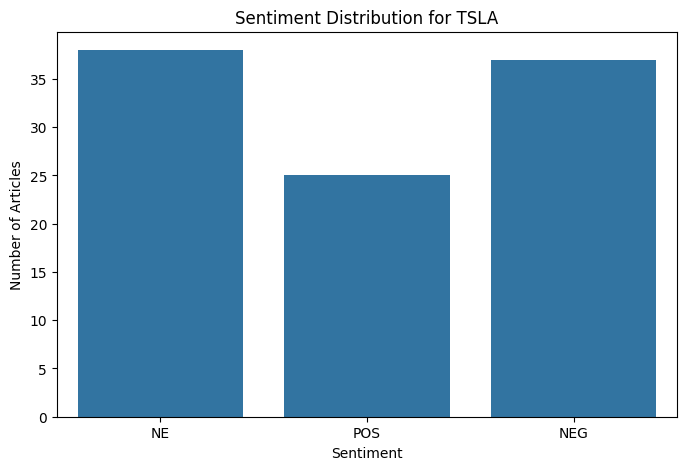

In [47]:
# Simple Bar Chart
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=news_df)
plt.title(f"Sentiment Distribution for {ticker}")
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.show()

Word Cloud for the Sentiment Analysis

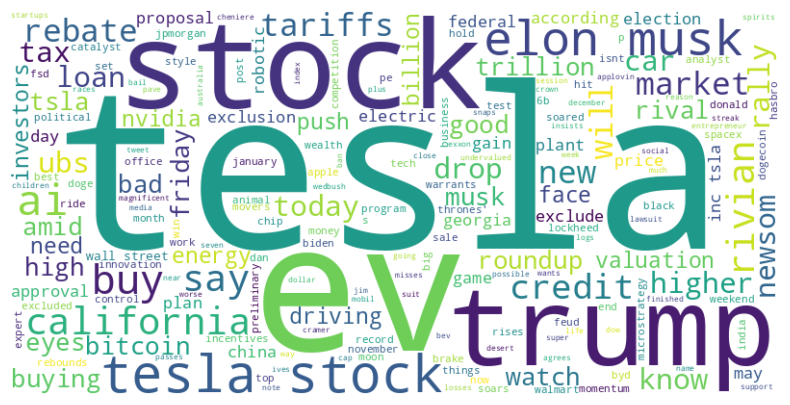

In [48]:
# Combine all the titles into a single string
text = " ".join(news_df['Title'].tolist())

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Function to convert labels to numeric values

In [49]:
# Convert sentiment labels to numeric values, handling potential variations
def convert_sentiment_to_numeric(sentiment):
    if sentiment.startswith('POS'):  # Check if sentiment starts with 'POS'
        return 1
    elif sentiment.startswith('NEG'):  # Check if sentiment starts with 'NEG'
        return -1
    else:
        return 0  # If NE or "NEUTRAL", return 0

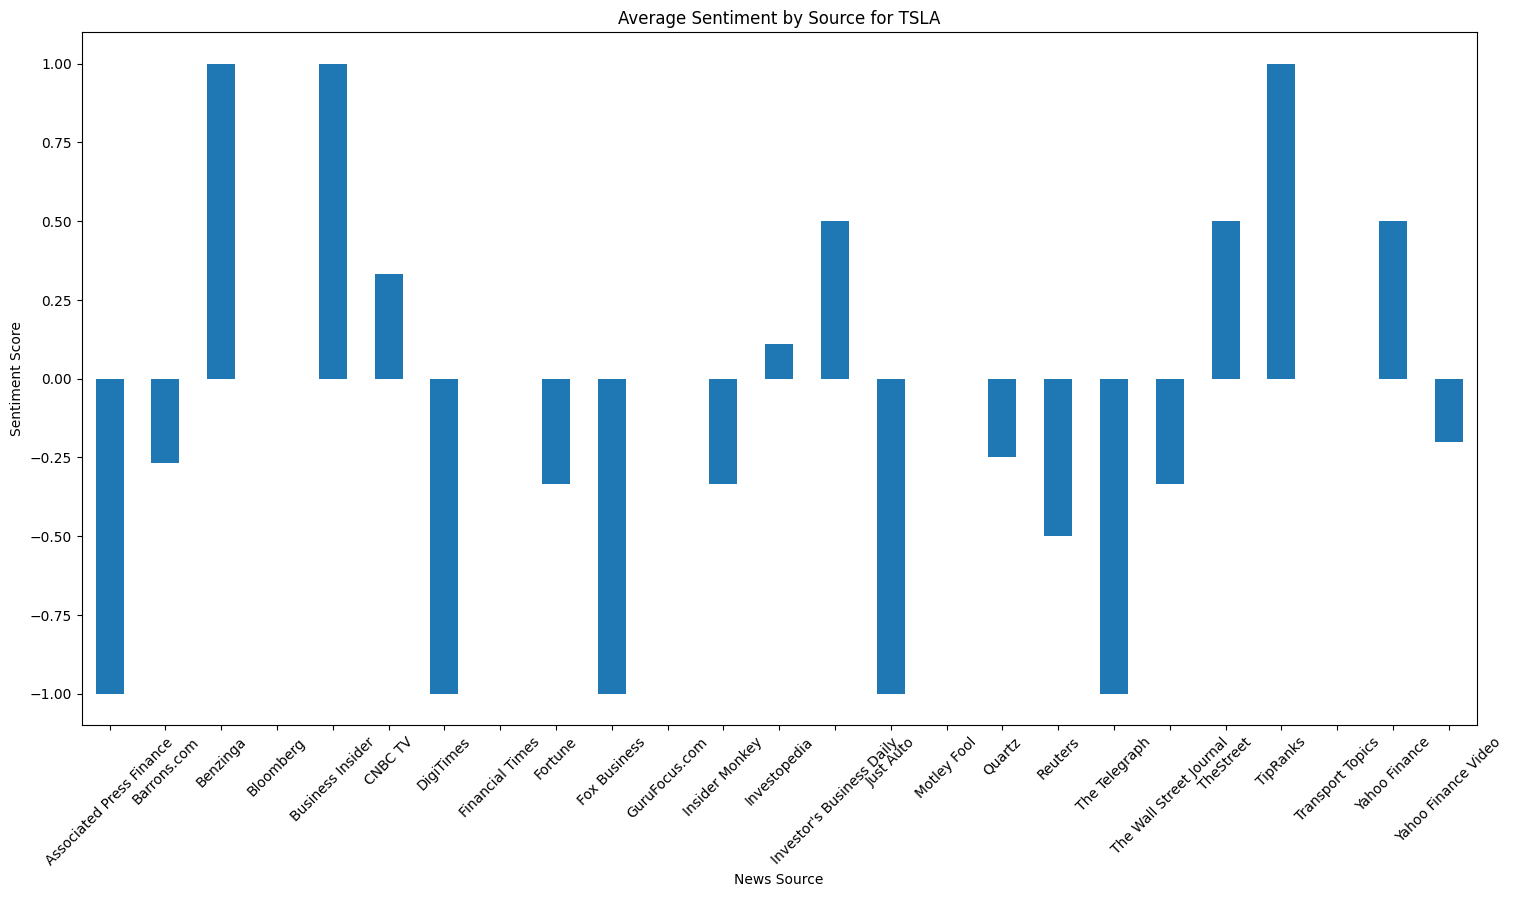

In [53]:
news_df['sentiment_numeric'] = news_df['sentiment'].apply(convert_sentiment_to_numeric)

# Group by 'Source' and calculate the average sentiment
source_sentiment = news_df.groupby('Source')['sentiment_numeric'].mean()

# Create a bar chart
plt.figure(figsize=(18, 9))
source_sentiment.plot(kind='bar')
plt.title(f"Average Sentiment by Source for {ticker}")
plt.xlabel("News Source")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.show()